<a href="https://colab.research.google.com/github/EmperorNao/MLHub/blob/main/examples/ipynb/TitanicForTMV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!wget https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv

--2022-02-13 11:16:05--  https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200, 2607:f6d0:0:925a::ab43:d7c8
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44225 (43K) [text/csv]
Saving to: ‘titanic.csv’

titanic.csv         100%[===================>]  43.19K  --.-KB/s    in 0.1s    

2022-02-13 11:16:05 (423 KB/s) - ‘titanic.csv’ saved [44225/44225]



In [11]:
import pandas as pd
import numpy as np
from math import ceil
from sklearn import linear_model
import matplotlib.pyplot as plt

In [12]:
class DimensionsException(Exception):

    def __init__(self, s):
        self.msg = s
        super().__init__()

    def __str__(self):
        return self.msg

In [13]:

def one_hot_encoding(x: pd.DataFrame) -> np.ndarray:

    unique = x.unique()

    ohe = np.zeros([len(x), len(unique)])
    for i, kv in enumerate(x.iteritems()):
        index, v = kv
        ohe[i][np.where(unique == v)] = 1

    return ohe


def scale(x: np.ndarray) -> np.ndarray:

    z = ((x - x.mean()) / x.std())
    return z


def titanic(df):

    #df = df.dropna()
    df = df.apply(lambda x: x.fillna(x.value_counts().index[0]))
    numerical = ['Age', 'Fare', ]
    categorical = ['Pclass', 'Sex']
    target = ['Survived']

    #df.columns = columns
    un = df[target].iloc[:, 0].unique()
    y = (df[target] == un[0]).to_numpy(dtype="int")
    x = []

    processed = []
    # one-hot-encoding categorical
    for col in categorical:
        x.append(one_hot_encoding(df[col]))

    # забавный факт - скейл нумерикал фич приводит к ужасному реколлу, поэтому делать мы его не будем
    x += [np.expand_dims(df[col].to_numpy(), -1) for col in numerical]
    for col in numerical:
        x.append(np.expand_dims(scale(df[col].to_numpy()), -1))

    for ohe in processed:
        x.append(scale(ohe))

    return np.hstack(x), y


def get_dataset(name) -> (np.ndarray, np.ndarray):

    if name == "titanic":

        df = pd.read_csv(r"titanic.csv")
        return titanic(df)


def train_test_split(x: np.ndarray,
                     y: np.ndarray,
                     ratio: float = 0) -> ((np.ndarray, np.ndarray), (np.ndarray, np.ndarray)):

    if x.shape[0] != y.shape[0]:
        raise DimensionsException("X and y has different number of objects")

    if 1 < ratio < 0:
        raise ValueError(f"Ratio need to be in [0, 1], provided {ratio}")

    idx_full = range(0, x.shape[0])
    size = ceil(x.shape[0] * ratio)
    idx_train = list(np.random.choice(idx_full, size))
    idx_test = list(set(idx_full).difference(idx_train))

    return (x[idx_train, :], x[idx_test, :]), (y[idx_train], y[idx_test])


In [14]:

def sgd(x: np.ndarray,
        y: np.ndarray,
        loss_fn, grad_loss_fn,
        lr = 1e-4,
        smart_init=False,
        w: np.ndarray = None,
        lam: float = 0.9,
        eps=1e-6,
        batch_size=1, # менять bs нельзя, данный метод не работает для нескольких элементов в батче
        max_iter=10000,
        logging=False) -> (np.ndarray, float):

    n_features = x.shape[1]
    n_objects = x.shape[0]

    if w is None:
        if not smart_init:
            w = np.zeros(n_features)
            for i in range(n_features):
                w[i] = np.random.normal(0, 1 / (2 * x.shape[0]))

        w = np.expand_dims(w, -1)

    grad_coef = np.asarray([grad_loss_fn(w, np.expand_dims(x[i], 0), y[i]) for i in range(n_objects)])
    grad_sum = np.sum(grad_coef, axis=0)


    delta_q = float("inf")
    delta_w = np.array([float("inf")] * n_features)
    loss = loss_fn(w, x, y)
    q = np.sum(loss) / x.shape[0]

    history = []
    iter = 0

    if logging:
        print(f"Iter = {iter}, Loss = {q}")

    while iter < max_iter and abs(delta_q) > eps:# or abs(np.sum(delta_w)) > (eps * n_features)):

        idx_obj = np.random.choice(range(n_objects), size=batch_size)
        x_obj = x[idx_obj,:]
        y_obj = y[idx_obj]

        loss = np.sum(loss_fn(w, x_obj, y_obj)) / x_obj.shape[0]

        grad = grad_loss_fn(w, x_obj, y_obj)
        grad_sum -= grad_coef[idx_obj[0]]
        grad_coef[idx_obj[0]] = grad
        grad_sum += grad_coef[idx_obj[0]]

        delta_w = lr * grad_sum / n_objects
        w = w - delta_w

        new_q = lam * loss + (1 - lam) * q
        delta_q = new_q - q
        q = new_q

        #print(f"iter {iter}\ngrad = {grad}\ndelta w = {delta_w}\ndelta q = {delta_q}\n\n")
        iter += 1
        history.append(q)

        if logging:
            print(f"Iter = {iter}, Loss = {q}, delta_w = {delta_w}")

    return w, q, history


class SGDOptimizer:

    def __init__(self,
                 lr: float =1e-4,
                 smart_init=False,
                 lam: float = 0.9,
                 eps = 1e-6,
                 max_iter = 10000,
                 logging=False):

        self.lr = lr
        self.smart_init = smart_init
        self.lam = lam
        self.eps = eps
        self.max_iter = max_iter
        self.logging = logging

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            loss_fn,
            grad_loss_fn,
            w: np.ndarray = None,
            get_hist=False) -> (np.ndarray, float):
        # weight and quality

        res = sgd(x, y, loss_fn, grad_loss_fn,
                   self.lr, self.smart_init, w, self.lam, self.eps, 1, self.max_iter, self.logging)

        if get_hist:
            return res

        else:
            return res[0], res[1]


In [15]:
def accuracy(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    return np.mean(y_real == y_pred)


def precision(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    pos_idx = np.argwhere(y_real == 1)
    return np.sum(y_real[pos_idx] == y_pred[pos_idx]) / (np.sum(y_real[pos_idx] == y_pred[pos_idx]) + np.sum(y_real[pos_idx] != y_pred[pos_idx]))


def recall(y_real: np.ndarray, y_pred: np.ndarray) -> float:

    pos_neg = np.argwhere(y_real == 0)
    return np.sum(y_real[pos_neg] == y_pred[pos_neg]) / (np.sum(y_real[pos_neg] == y_pred[pos_neg]) + np.sum(y_real[pos_neg] != y_pred[pos_neg]))

In [16]:
class LogisticRegression:

    def __init__(self, weights: np.ndarray = None, L2_coefficient: float = 0, logging=False):

        self.weights = weights
        self.L2_coefficient = L2_coefficient if L2_coefficient != 0 else 0.05
        self.logging=logging

    def fit(self, x: np.ndarray, y: np.ndarray, optimizer):

        if x.shape[0] != y.shape[0]:
            raise DimensionsException("X and y has different number of objects")

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        self.classes = np.unique(y)

        n_classes = self.classes.shape[0]

        ones = 1 * np.ones((n_objects, 1))

        self.weights = np.random.normal(scale=1/(2 * np.pi * x.shape[0]), size=(n_features, n_classes))

        x_padded = np.hstack([x, ones])

        y_transformed = []
        for el_y in y:
            z = np.zeros(n_classes)
            z[np.where(self.classes == el_y)] = 1
            y_transformed.append(z)

        w, q, history = optimizer.fit(x_padded, np.array(y_transformed), self.loss, self.grad_loss, w=self.weights, get_hist=True)

        self.weights = w
        return history

    def softmax(self, v):
        # v = m * k
        # outp = m * k

        exp = np.exp(v)
        denom = np.expand_dims(np.sum(exp, axis=1), -1)
        ret = exp / denom
        return ret

    def softmax_grad(self, v):
        # v = m x k
        # outp = m x k x k

        sm = self.softmax(v)
        m = v.shape[0]
        c = v.shape[1]
        return np.array(np.array([np.array([sm[k][i] * (1 - sm[i]) if i == j else -1 * sm[k][i] * sm[k][j] for i in range(c)]) for j in range(c)]) for k in range(m))

    def loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x k
        # w.shape = k x n
        # outp = k x 1

        # sm(k x n * n x m = k x m)

        sm = self.softmax(np.dot(x, w))
        return -1 * np.mean(np.sum(y * np.log(sm), axis=1), axis=0)

    def grad_loss(self, w: np.ndarray, x: np.ndarray, y: np.ndarray):
        # x.shape = m x n
        # y.shape = m x k
        # w.shape = k x n
        # outp =

        # sm(k x n * n x m = k x m)
        sm = self.softmax(np.dot(x, w))
        prod = sm * y
        diff = prod - y
        return np.dot(x.T, diff)

    def predict(self, x: np.ndarray) -> np.ndarray:

        n_objects = x.shape[0]
        n_features = x.shape[1] + 1
        ones = 1 * np.ones((n_objects, 1))

        x_padded = np.hstack([x, ones])

        prob = self.softmax(self.softmax(np.dot(x_padded, self.weights)))
        pred = np.argmax(prob, axis=1)
        if self.logging:
            print(prob)
            print(pred)

        return pred

In [17]:
def titanic_example():

    np.random.seed(42)
    x, y = get_dataset("titanic")

    optim = SGDOptimizer(lr=1e-4, max_iter=1000, lam=0.85)
    simple = LogisticRegression()
    sklearn = linear_model.LogisticRegression(max_iter=100)

    x_pair, y_pair = train_test_split(x, y, ratio=0.75)

    x_train, x_test = x_pair
    y_train, y_test = y_pair

    y_test = np.squeeze(y_test, -1)

    history = simple.fit(x_train, y_train, optim)
    sklearn.fit(x_train, np.squeeze(y_train, -1))

    y_pred_simple = simple.predict(x_test)
    y_pred_sklearn = sklearn.predict(x_test)

    print(f"ACC on SLKEARN = {accuracy(y_test, y_pred_sklearn)}")
    print(f"ACC on our LR = {accuracy(y_test, y_pred_simple)}")

    print(f"precision on SLKEARN = {precision(y_test, y_pred_sklearn)}")
    print(f"precision on our LR = {precision(y_test, y_pred_simple)}")

    print(f"recall on SLKEARN = {recall(y_test, y_pred_sklearn)}")
    print(f"recall on our LR = {recall(y_test, y_pred_simple)}")

    pos_index = np.where(y_test == 1)
    neg_index = np.where(y_test == 0)
    print(f"SKLEARN:\n"
          f"TP = {np.sum(y_test[pos_index] == y_pred_sklearn[pos_index])}\n"
          f"FP = {np.sum(y_test[pos_index] != y_pred_sklearn[pos_index])}\n"
          f"FN = {np.sum(y_test[neg_index] != y_pred_sklearn[neg_index])}\n"
          f"TN = {np.sum(y_test[neg_index] == y_pred_sklearn[neg_index])}")

    print(f"LR:\n"
          f"TP = {np.sum(y_test[pos_index] == y_pred_simple[pos_index])}\n"
          f"FP = {np.sum(y_test[pos_index] != y_pred_simple[pos_index])}\n"
          f"FN = {np.sum(y_test[neg_index] != y_pred_simple[neg_index])}\n"
          f"TN = {np.sum(y_test[neg_index] == y_pred_simple[neg_index])}")

    fig = plt.figure(figsize=(15, 10))

    plt.title("Loss")
    plt.plot([i for i in range(len(history))], history)
    plt.show()

Заметно, что лосс очень шумный

Кроме того, z-scale на num features приводит к recall нашей LogReg на уровне 0.15 (почему - не ясно?)

Очевидно, что зависимости не очень линейная. (Хотя, на самом делел, стандартный SKLearn сходится неплохо, поэтому, скорее дело в оптимизаторе)
Также очевидно, что SAGD сходится к локальному минимуму, потому что от запуска к запуску результаты рандомные (либо это может быть из-за маленькой выборки, также, но менее вероятно).

ACC on SLKEARN = 0.792147806004619
ACC on our LR = 0.7090069284064665
precision on SLKEARN = 0.8478260869565217
precision on our LR = 0.8369565217391305
recall on SLKEARN = 0.6942675159235668
recall on our LR = 0.4840764331210191
SKLEARN:
TP = 234
FP = 42
FN = 48
TN = 109
LR:
TP = 231
FP = 45
FN = 81
TN = 76


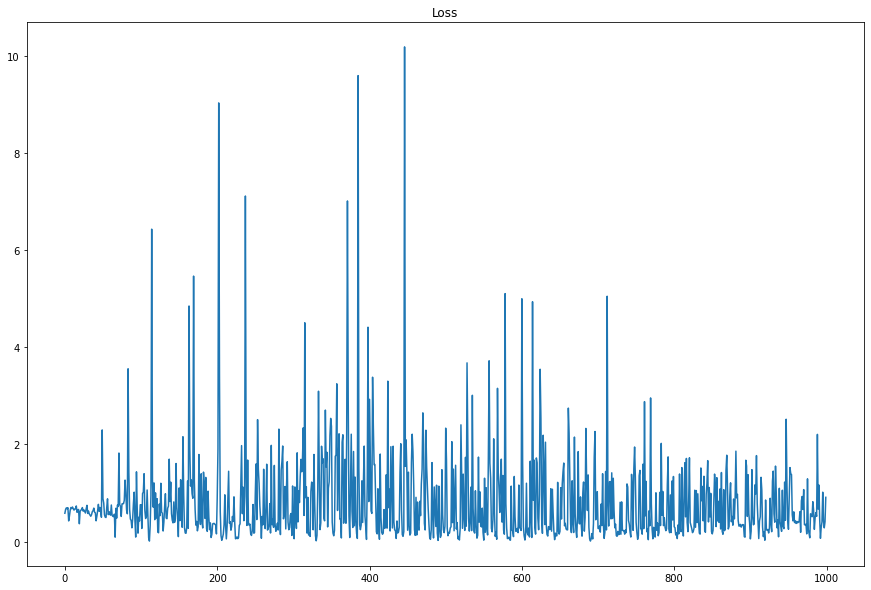

In [18]:
titanic_example()